# Techniques and Tests for Time Series Data in Python

Adapted and Updated from [A comprehensive beginner’s guide to create a Time Series Forecast](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/). 

Modeling continued in...

## Libraries and Import Data

In [1]:
# data analysis and graphing libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
# stats models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_csv('data/sample/AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.columns = ['value']

# optional alternative data to try
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

ts = df['value']

# Checking for stationarity

## Plot the time-series

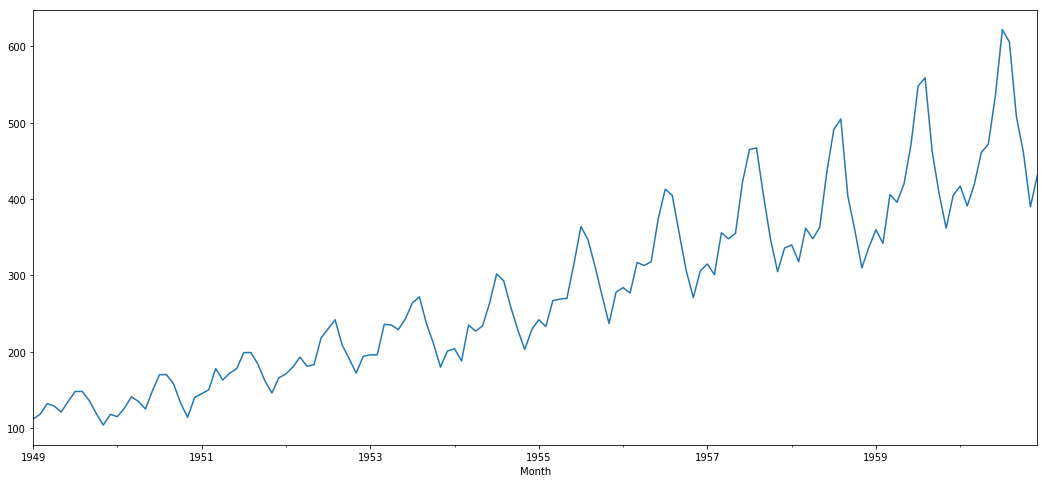

In [4]:
fig = plt.figure(figsize=(18,8))
ts.plot()
plt.show()

## Check Autocorrelation

In [5]:
test_ts = ts.reset_index(drop=True)

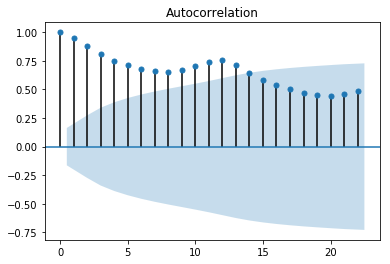

In [6]:
plot_acf(test_ts)
plt.show()

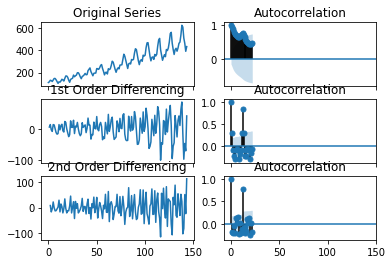

In [7]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(test_ts); axes[0, 0].set_title('Original Series')
plot_acf(test_ts, ax=axes[0, 1]) # lags=100

# 1st Differencing
axes[1, 0].plot(test_ts.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(test_ts.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(test_ts.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(test_ts.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## Function for Testing Stationarity

In [8]:
def test_stationarity(timeseries):
    
    # set figure size
    fig = plt.figure(figsize=(18,8))
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() 
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Function for Possible ARIMA Model Parameters

In [9]:
from pmdarima.arima.utils import ndiffs

def test_arima(timeseries):
    Adf_Test = ndiffs(timeseries, test='adf')  
    KPSS_Test = ndiffs(timeseries, test='kpss')  
    PP_Test = ndiffs(timeseries, test='pp')  

    print(Adf_Test, KPSS_Test, PP_Test) 

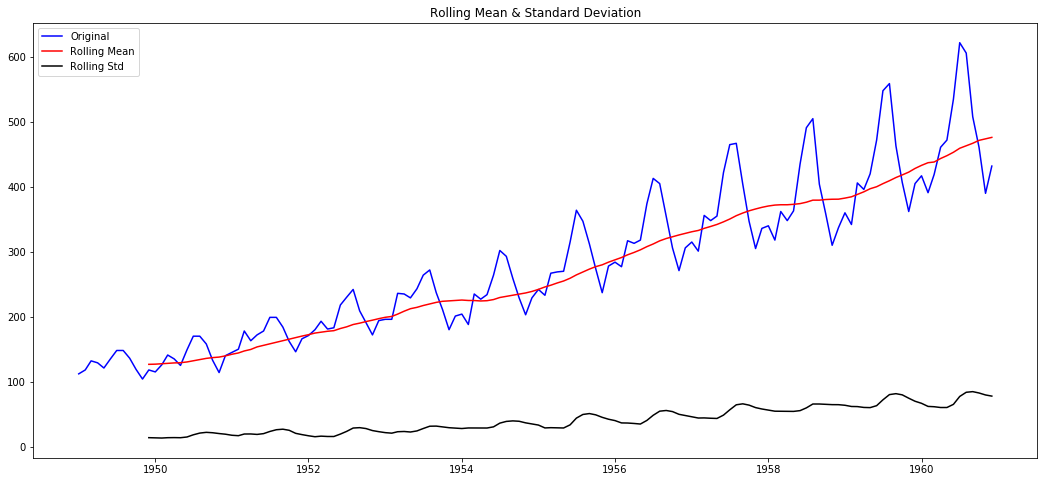

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
0 1 0


In [10]:
test_stationarity(ts)
test_arima(ts)

# Making Time Series Stationary

## Estimating & Eliminating Trend

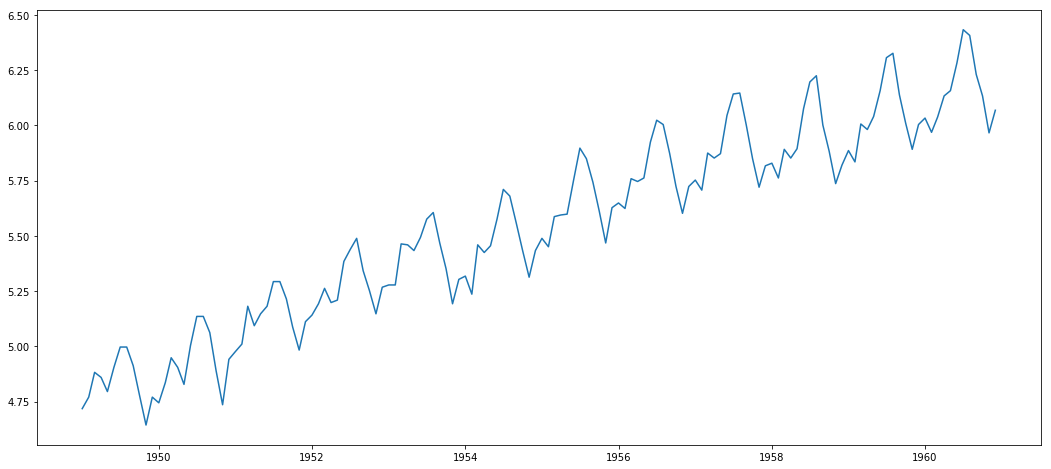

In [11]:
fig = plt.figure(figsize=(18,8))
ts_log = np.log(ts)
plt.plot(ts_log)

## Smoothing:

### Moving average

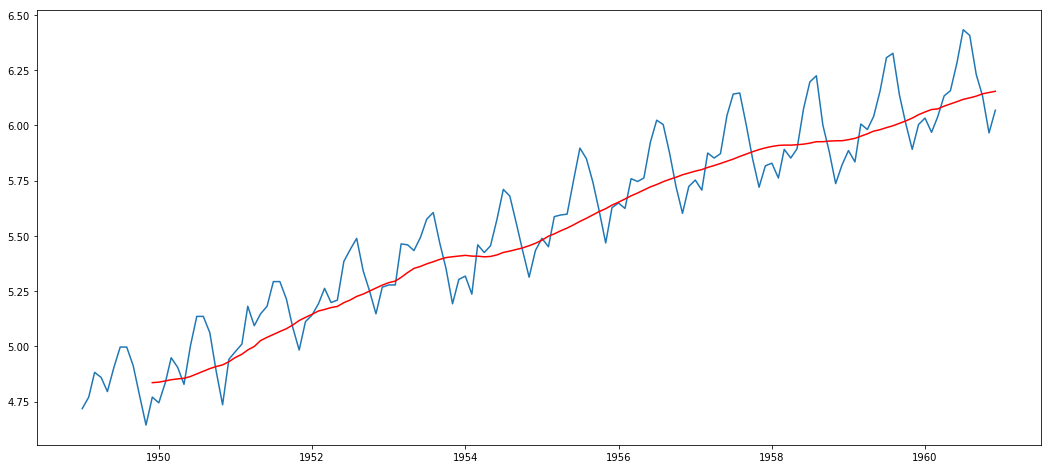

In [12]:
fig = plt.figure(figsize=(18,8))
moving_avg = ts_log.rolling(window=12).mean() 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
# export results
ts_log.to_csv('data/sample/ts_log.csv')

In [14]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: value, dtype: float64

In [15]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: value, dtype: float64

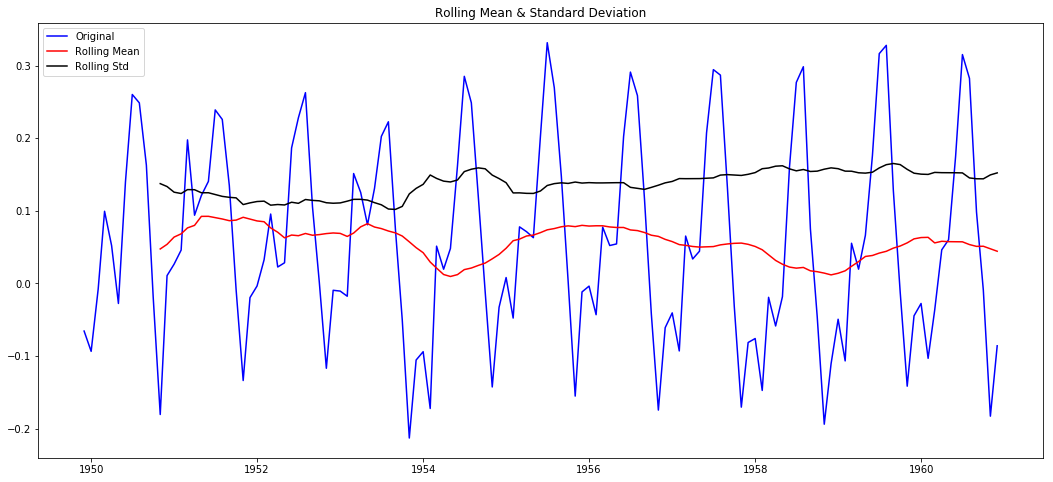

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
0 0 0


In [16]:
test_stationarity(ts_log_moving_avg_diff)
test_arima(ts_log_moving_avg_diff)

### Exponentially Weighted Moving Average

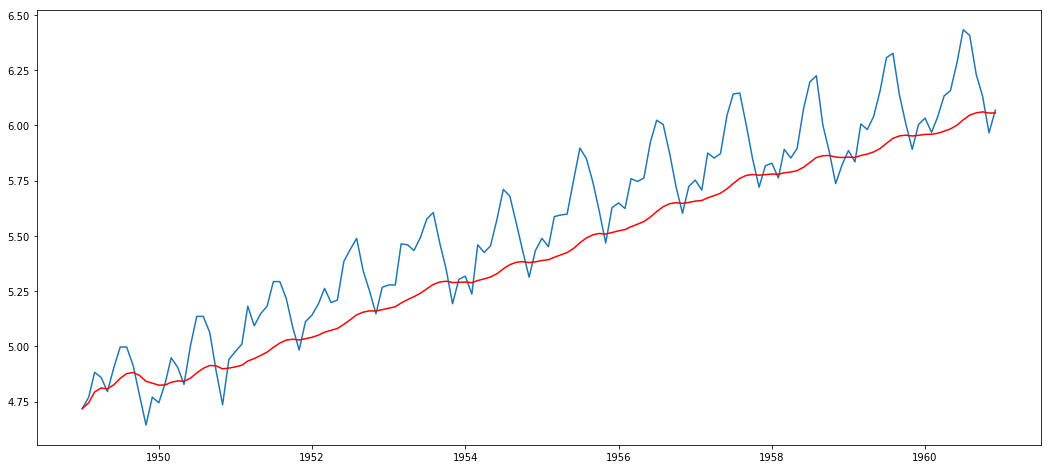

In [17]:
fig = plt.figure(figsize=(18,8))
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

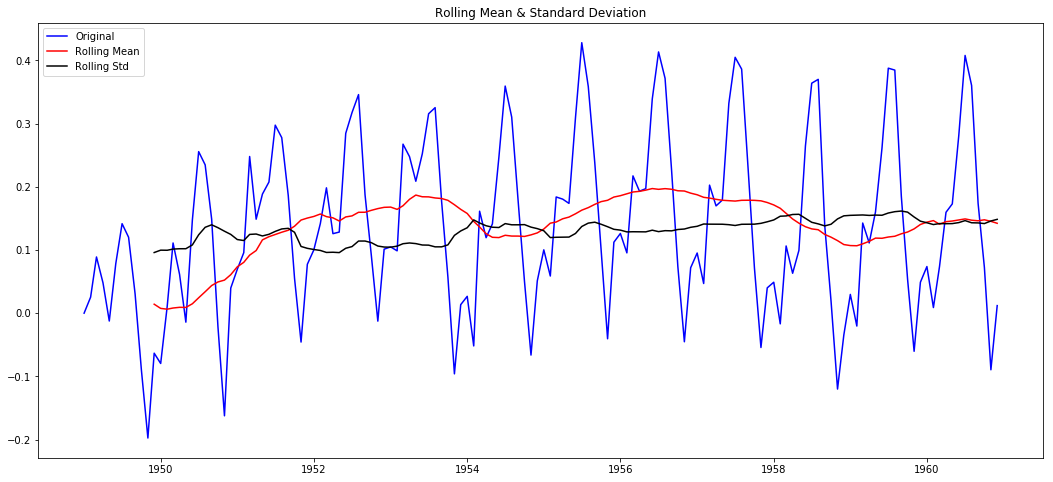

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
0 0 0


In [18]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)
test_arima(ts_log_moving_avg_diff)

## Eliminating Trend and Seasonality

### Differencing:

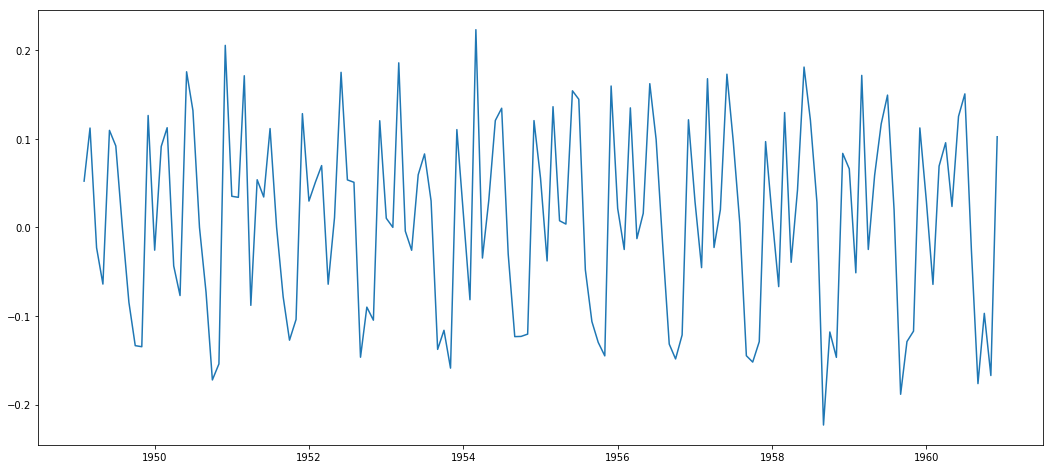

In [19]:
fig = plt.figure(figsize=(18,8))

#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

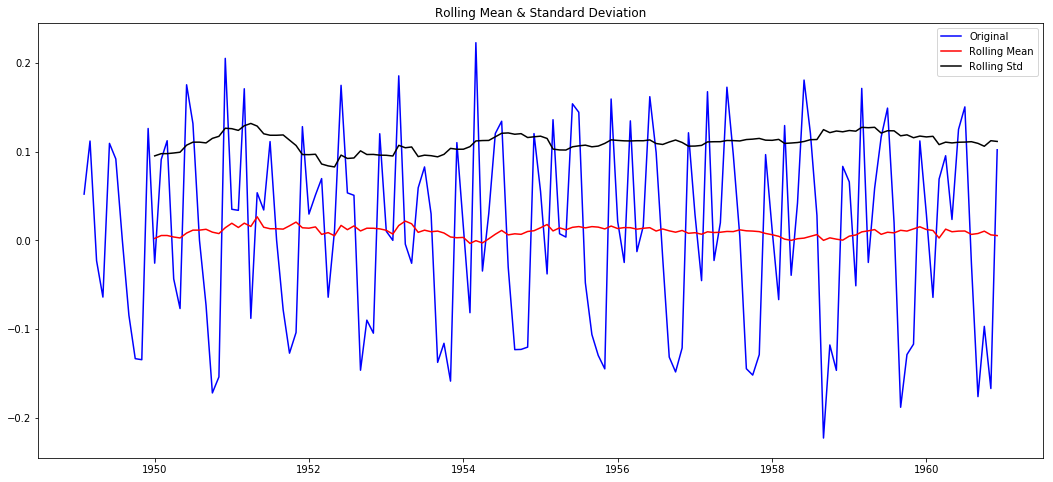

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
0 0 0


In [20]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
test_arima(ts_log_diff)

In [21]:
# export results
ts_log_diff.to_csv('data/sample/ts_log_diff.csv')

### Decomposition:

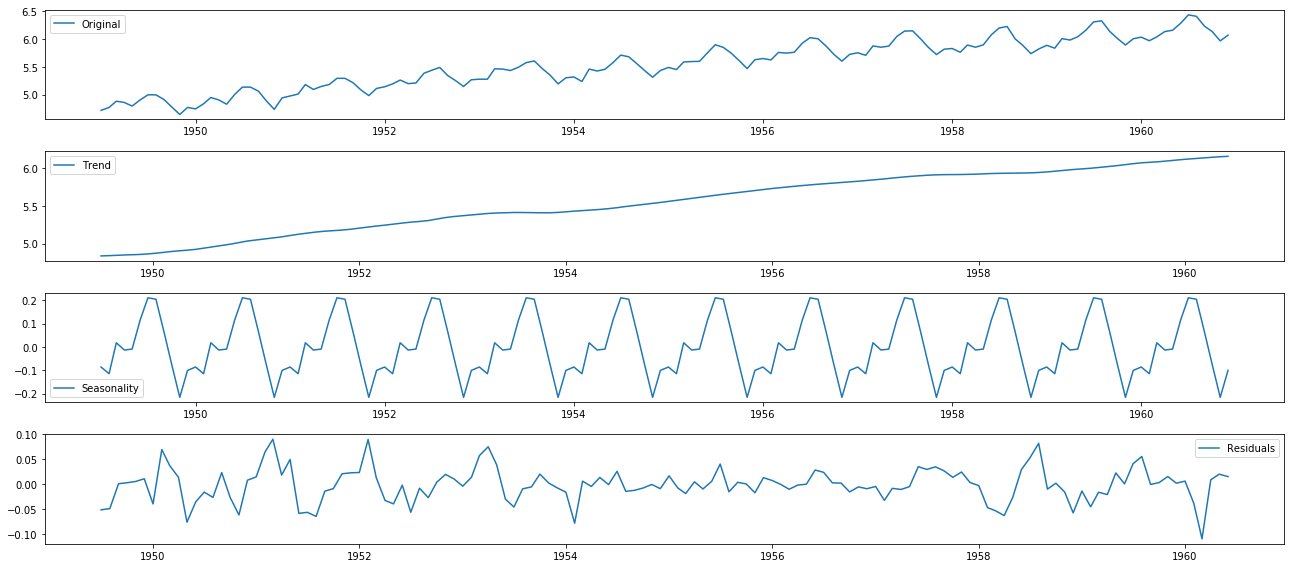

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(18,8))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

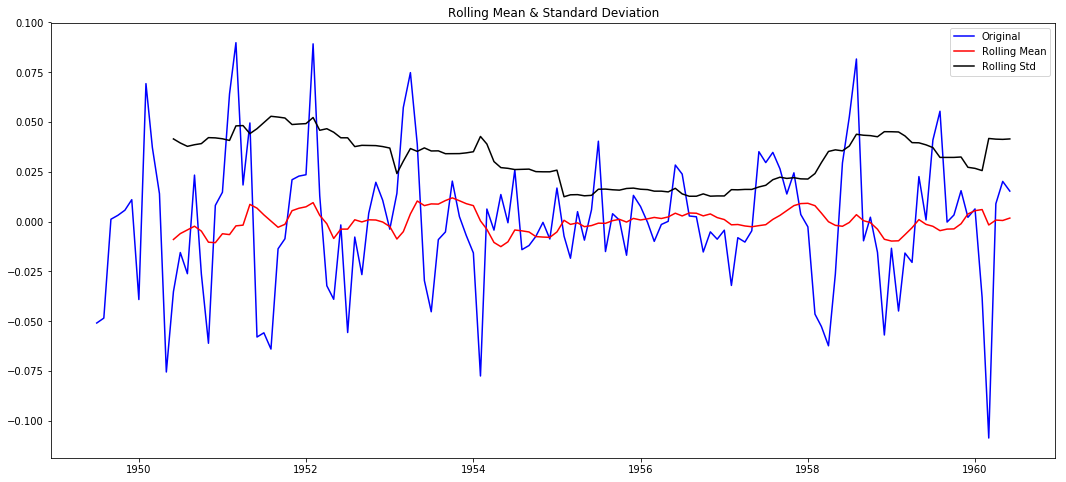

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [23]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [24]:
# export results
ts_log_decompose.to_csv('data/sample/ts_log_decompose.csv')